<a href="https://colab.research.google.com/github/elain-b/Climate_change_LSTM/blob/master/Climate_change_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# show upload dialog
from google.colab import files
uploaded = files.upload()

Saving Maximum_monthly_temperature.csv to Maximum_monthly_temperature.csv


In [0]:
import pandas as pd
Maximum_monthly_temperature = pd.read_csv('./Maximum_monthly_temperature.csv',  engine='python', header=1,index_col=0,encoding = 'shift_jis')
print(Maximum_monthly_temperature.tail())

                Sapporo/Highest temperature  ...  Fukuoka/Highest temperature2
Year and month                               ...                              
2018/9                                 28.2  ...                             1
2018/10                                22.1  ...                             1
2018/11                                17.9  ...                             1
2018/12                                13.0  ...                             1
2019/1                                  4.1  ...                             1

[5 rows x 18 columns]


(1765, 6)
(1765, 6)
(1765, 6)
(array([], dtype=float64), array([], dtype=float64))
Epoch 1/1
 - 6s - loss: 0.0316
Train Score: 0.07 RMSE
Test Score: 0.07 RMSE


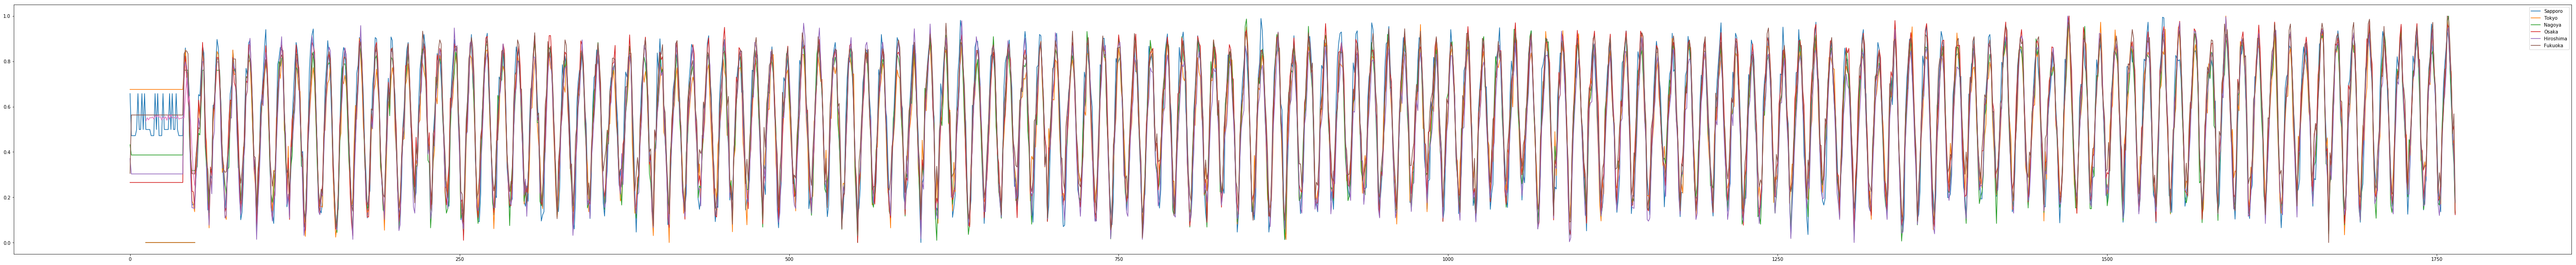

In [0]:
import pandas as pd
import numpy as np
import math
import knnimpute as knnimp
import matplotlib.pyplot as plt
from IPython.core.display import display
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers.recurrent import SimpleRNN, LSTM
from keras.layers import Dense, Activation, Dropout
from sklearn.metrics import mean_squared_error

def pre_function(input_data):
    input_data = input_data.reset_index()
    input_data = input_data.drop( [0,1] ,axis=0)
    return input_data

def delete_nun(pre_data):
    pre_data = pre_data.drop(columns=["level_0",0])
    pre_data = pre_data.astype(np.float32)
    matrix = pre_data.values
    missing_mask = np.isnan(matrix)
    result = knnimp.knn_impute_few_observed(matrix, missing_mask, 3)
    pre_data = pd.DataFrame(result, columns = pre_data.columns)
    if 'level_23' in pre_data.columns:
        pre_data = pre_data.drop(columns=["level_2","level_3","level_4","level_6","level_7","level_8","level_10","level_11","level_12","level_14","level_15","level_16","level_18","level_19","level_20","level_22","level_23"])
    elif 'level_17' in pre_data.columns:
        pre_data = pre_data.drop(columns=["level_2","level_3","level_5","level_6","level_8","level_9","level_11","level_12","level_14","level_15","level_17"])
    return pre_data


def read_temperature(csv_file):
    temperature = pd.read_csv(csv_file, engine='python',  encoding = 'shift_jis',header=None)
    temperature =pre_function(temperature)
    temperature = delete_nun(temperature)
    #display(temperature)
    return temperature

# 1872~2019, 札幌、東京、名古屋、大阪、広島、福岡
Maximum_monthly_temperature = read_temperature('./Maximum_monthly_temperature.csv')

scaler = MinMaxScaler()
Maximum_monthly_temperature = scaler.fit_transform(Maximum_monthly_temperature)

print(scaler.fit_transform(Maximum_monthly_temperature).shape)
print(scaler.inverse_transform(Maximum_monthly_temperature).shape)

train_size = int(len(Maximum_monthly_temperature) * 0.67)
test_size = len(Maximum_monthly_temperature) - train_size
train, test = Maximum_monthly_temperature[0:train_size,:], Maximum_monthly_temperature[train_size:len(Maximum_monthly_temperature),:]

def create_dataset(Maximum_monthly_temperature, look_back=1):
    dataX, dataY = [], []
    for i in range(len(Maximum_monthly_temperature)-look_back-1):
        xset = []
        for j in range(Maximum_monthly_temperature.shape[1]):
            a = Maximum_monthly_temperature[i:(i+look_back), j]
            xset.append(a)
        dataY.append(Maximum_monthly_temperature[i + look_back, 0])      
        dataX.append(xset)
    return np.array(dataX), np.array(dataY)

look_back = 12
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], trainX.shape[2]))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], testX.shape[2]))

model = Sequential()
model.add(LSTM(4, input_shape=(testX.shape[1], look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=1, batch_size=1, verbose=2)

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
pad_col = np.zeros(Maximum_monthly_temperature.shape[1]-1)

# invert predictions
def pad_array(val):
    return np.array([np.insert(pad_col, 0, x) for x in val])

trainPredict = scaler.inverse_transform(pad_array(trainPredict))
trainY = scaler.inverse_transform(pad_array(trainY))
testPredict = scaler.inverse_transform(pad_array(testPredict))
testY = scaler.inverse_transform(pad_array(testY))

trainScore = math.sqrt(mean_squared_error(trainY[:,0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[:,0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# print(testY[:,0])
# print(testPredict[:,0])

# 1枚にプロット
# shift train predictions for plotting
trainPredictPlot = np.empty_like(Maximum_monthly_temperature)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(Maximum_monthly_temperature)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(Maximum_monthly_temperature)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(100,10))
plt.plot(scaler.inverse_transform(Maximum_monthly_temperature)[ : ,0], label="Sapporo"[:50])
plt.plot(scaler.inverse_transform(Maximum_monthly_temperature)[ : ,1], label="Tokyo"[:50])
plt.plot(scaler.inverse_transform(Maximum_monthly_temperature)[ : ,2], label="Nagoya"[:50])
plt.plot(scaler.inverse_transform(Maximum_monthly_temperature)[ : ,3], label="Osaka"[:50])
plt.plot(scaler.inverse_transform(Maximum_monthly_temperature)[ : ,4], label="Hiroshima"[:50])
plt.plot(scaler.inverse_transform(Maximum_monthly_temperature)[ : ,5], label="Fukuoka"[:50])
plt.plot(trainPredictPlot[:50])
plt.plot(testPredictPlot[:50])
plt.legend() 
plt.show()

# shift train predictions for plotting
#print(len(Maximum_monthly_temperature))
trainPredictPlot = np.empty_like(Maximum_monthly_temperature)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(Maximum_monthly_temperature)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(Maximum_monthly_temperature)-1, :] = testPredict

# 100年ごと
# plot baseline and predictions
# for i in range(18):
#     print(i*100, "~", (i+1)*100)
#     fig = plt.figure(figsize=(10,6))
#     plt.plot(scaler.inverse_transform(Maximum_monthly_temperature)[i*100:(i+1)*100,:])
#     plt.plot(trainPredictPlot[i*100:(i+1)*100,:])
#     plt.plot(testPredictPlot[i*100:(i+1)*100,:])
#     plt.show()

# 100年ごととラベル
# for i in range(18):
#     print("index:", i*100, "~", (i+1)*100)
#     fig = plt.figure(figsize=(10,6))
#     plt.plot(scaler.inverse_transform(Maximum_monthly_temperature)[i*100:(i+1)*100,0], label="Sapporo")
#     plt.plot(scaler.inverse_transform(Maximum_monthly_temperature)[i*100:(i+1)*100,1], label="Tokyo")
#     plt.plot(scaler.inverse_transform(Maximum_monthly_temperature)[i*100:(i+1)*100,2], label="Nagoya")
#     plt.plot(scaler.inverse_transform(Maximum_monthly_temperature)[i*100:(i+1)*100,3], label="Osaka")
#     plt.plot(scaler.inverse_transform(Maximum_monthly_temperature)[i*100:(i+1)*100,4], label="Hiroshima")
#     plt.plot(scaler.inverse_transform(Maximum_monthly_temperature)[i*100:(i+1)*100,5], label="Fukuoka")
#     plt.plot(trainPredictPlot[i*100:(i+1)*100, :], label="Train")
#     plt.plot(testPredictPlot[i*100:(i+1)*100, :], label="Test")
#     plt.legend() 
#     plt.show()
    
# # plt.plot(correct_dataset_plt, label='Correct prediction')
# plt.plot(trainPredict[:100,0], label='Train')
# plt.plot(testPredict[:100,0], label='Test')
# # # plt.plot(nest_plt, label='Next prediction', c='r')
# plt.legend() 
# plt.show()
# # len(trainPredict[:,0])

# 50年ごと
# for i in range(18):
#     print("index:", i*50, "~", (i+1)*50)
#     fig = plt.figure(figsize=(10,6))
#     plt.plot(scaler.inverse_transform(Maximum_monthly_temperature)[i*50:(i+1)*50,0], label="Sapporo")
#     plt.plot(trainPredictPlot[i*50:(i+1)*50, :], label="Train")
#     plt.plot(testPredictPlot[i*50:(i+1)*50, :], label="Test")
#     plt.legend() 
#     plt.show()
    
# 東京/train/testでプロットしたかったがエラー/2019~2029
# x= np.arange(start=2019,stop=2029)
# fig = plt.figure(figsize=(10,6))
# plt.plot(x,scaler.inverse_transform(Maximum_monthly_temperature)[2019:2029,1], label="Tokyo")
# plt.plot(x,trainPredictPlot[2019:2029, :], label="Train")
# plt.plot(x,testPredictPlot[2019:2029, :], label="Test")
# plt.legend() 
# plt.show()

# 東京/train/testでプロットしたかったがエラー/2019~2029
# x= np.arange(start=2019,stop=2029)
# fig = plt.figure(figsize=(10,6))
# plt.plot(x,scaler.inverse_transform(Maximum_monthly_temperature)[2019:2029,1], label="Tokyo")
# plt.plot(x,np.array(trainPredictPlot[2019:2029, :]), label="Train")
# plt.plot(x,np.array(trainPredictPlot[2019:2029, :]), label="Test")
# plt.legend()
# plt.show()


In [0]:
import h5py
with h5py.File('output.h5', 'w') as f:

    f.create_dataset('Sapporo', data=(Maximum_monthly_temperature)[ : ,0])
    f.create_dataset('Tokyo', data=(Maximum_monthly_temperature)[ : ,1])
    f.create_dataset('Nagoya', data=(Maximum_monthly_temperature)[ : ,2])
    f.create_dataset('Osaka', data=(Maximum_monthly_temperature)[ : ,3])
    f.create_dataset('Hiroshima', data=(Maximum_monthly_temperature)[ : ,4])
    f.create_dataset('Fukuoka', data=(Maximum_monthly_temperature)[ : ,5])
    print(f['Sapporo'].value)

[0.65760864 0.47192027 0.47192027 ... 0.50271737 0.36956521 0.12771739]


In [0]:
# 気温予測flaskアプリ用
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import math
import knnimpute as knnimp
import matplotlib.pyplot as plt
from IPython.core.display import display
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers.recurrent import SimpleRNN, LSTM
from keras.layers import Dense, Activation, Dropout
from sklearn.metrics import mean_squared_error

def pre_function(input_data):
    input_data = input_data.reset_index()
    input_data = input_data.drop( [0,1] ,axis=0)
    return input_data

def delete_nun(pre_data):
    pre_data = pre_data.drop(columns=["level_0",0])
    pre_data = pre_data.astype(np.float32)
    matrix = pre_data.values
    missing_mask = np.isnan(matrix)
    result = knnimp.knn_impute_few_observed(matrix, missing_mask, 3)
    pre_data = pd.DataFrame(result, columns = pre_data.columns)
    if 'level_23' in pre_data.columns:
        pre_data = pre_data.drop(columns=["level_2","level_3","level_4","level_6","level_7","level_8","level_10","level_11","level_12","level_14","level_15","level_16","level_18","level_19","level_20","level_22","level_23"])
    elif 'level_17' in pre_data.columns:
        pre_data = pre_data.drop(columns=["level_2","level_3","level_5","level_6","level_8","level_9","level_11","level_12","level_14","level_15","level_17"])
    return pre_data


def read_temperature(csv_file):
    temperature = pd.read_csv(csv_file, engine='python',  encoding = 'shift_jis',header=None)
    temperature =pre_function(temperature)
    temperature = delete_nun(temperature)
    #display(temperature)
    return temperature

# 1872~2019, 札幌、東京、名古屋、大阪、広島、福岡
Maximum_monthly_temperature = read_temperature('./Maximum_monthly_temperature.csv')

scaler = MinMaxScaler()
Maximum_monthly_temperature = scaler.fit_transform(Maximum_monthly_temperature)

train_size = int(len(Maximum_monthly_temperature) * 0.67)
test_size = len(Maximum_monthly_temperature) - train_size
train, test = Maximum_monthly_temperature[0:train_size,:], Maximum_monthly_temperature[train_size:len(Maximum_monthly_temperature),:]
print(test)
print(len(test))
def create_dataset(Maximum_monthly_temperature, look_back=1):
    dataX, dataY = [], []
    for i in range(len(Maximum_monthly_temperature)-look_back-1):
        xset = []
        for j in range(Maximum_monthly_temperature.shape[1]):
            a = Maximum_monthly_temperature[i:(i+look_back), j]
            xset.append(a)
        dataY.append(Maximum_monthly_temperature[i + look_back, 0])      
        dataX.append(xset)
    return np.array(dataX), np.array(dataY)

look_back = 12
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print(testX)
print(len(testX))
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], trainX.shape[2]))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], testX.shape[2]))

model = Sequential()
model.add(LSTM(4, input_shape=(testX.shape[1], look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=1, batch_size=1, verbose=2)

model.save("model_save.h5")

[[0.91032611 0.84353746 0.8506494  0.88039872 0.78596484 0.85263155]
 [0.85054348 0.86394558 0.88636363 0.8936878  0.81052627 0.89473684]
 [0.78532605 0.86054427 0.79870127 0.84053158 0.8035087  0.84912283]
 ...
 [0.50271737 0.43197276 0.44155846 0.49169435 0.46315787 0.48070176]
 [0.36956521 0.45238093 0.34415587 0.51495019 0.37543858 0.56842106]
 [0.12771739 0.13265305 0.12987013 0.12292359 0.18245613 0.1754386 ]]
583
[[[0.91032611 0.85054348 0.78532605 ... 0.61141302 0.73913043 0.71739127]
  [0.84353746 0.86394558 0.86054427 ... 0.53741495 0.63605439 0.70068029]
  [0.8506494  0.88636363 0.79870127 ... 0.47727276 0.68506496 0.7175325 ]
  [0.88039872 0.8936878  0.84053158 ... 0.4817276  0.65448511 0.72757478]
  [0.78596484 0.81052627 0.8035087  ... 0.47017544 0.61754382 0.67719297]
  [0.85263155 0.89473684 0.84912283 ... 0.56842106 0.6877193  0.78596496]]

 [[0.85054348 0.78532605 0.66032609 ... 0.73913043 0.71739127 0.87771739]
  [0.86394558 0.86054427 0.54421769 ... 0.63605439 0.700